In [2]:
from IPython.display import Image
import pandas as pd

In [3]:
# read in trajectories data from parquet from data/_11_analysis_&_conclusions/trajectories.parquet
trajectories = pd.read_parquet('../data/_11_analysis_&_conclusions/trajectories.parquet')

display(trajectories)

,segment_id,cluster,is_most_typical,is_most_extreme,icao,start_timestamp,point_idx,x,y,z,heading_deg,ground_speed,time_sec,original_x,original_y
0,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,0,0.000000e+00,0.000000e+00,19200.0,316.40,394.70,0.00,0.00,0.00
1,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,1,3.720587e+01,5.492236e+03,19525.0,316.80,394.00,13.94,-3759.78,4003.76
2,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,2,3.472619e+01,1.745698e+04,19775.0,316.40,397.50,30.10,-12010.90,12668.29
3,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,3,7.503692e-13,3.524056e+04,20050.0,316.30,398.20,44.66,-24297.29,25525.26
4,11523328,-1,False,False,ab3d9a,2024-08-01 21:23:58.860000+00:00,4,-3.142208e+02,6.052945e+04,20275.0,315.70,402.40,62.85,-41960.80,43625.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159395,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,45,1.296399e+06,1.204487e+06,13875.0,278.80,242.80,309.21,-1208354.96,-1292794.19
1159396,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,46,1.370067e+06,1.183170e+06,13750.0,282.10,243.40,315.08,-1283341.61,-1276718.44
1159397,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,47,1.445585e+06,1.163164e+06,13675.0,280.80,245.40,318.35,-1360080.93,-1262079.64
1159398,12013506,2,False,False,c03197,2024-08-01 00:15:56.530000+00:00,48,1.523643e+06,1.146660e+06,13475.0,277.90,246.40,323.80,-1439108.05,-1251113.72


In [4]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Get the first segment_id
first_segment = trajectories['segment_id'].unique()[0]

# Filter data for first segment
segment_data = trajectories[trajectories['segment_id'] == first_segment]

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=segment_data['x'],
    y=segment_data['y'],
    z=segment_data['z'],
    mode='lines+markers',
    line=dict(
        width=2,
        color='blue'
    ),
    marker=dict(
        size=2,
        color='blue',
        opacity=0.8  # Added some transparency
    )
)])

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Path - Segment {first_segment}',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)  # Adjusted camera position
        ),
        aspectmode='cube',  # Forces a cubic aspect ratio
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    ),
    width=1000,
    height=800
)

# Display interactive plot
fig.show()

# Save static version for GitHub
pio.write_image(fig, "flight_path.png")

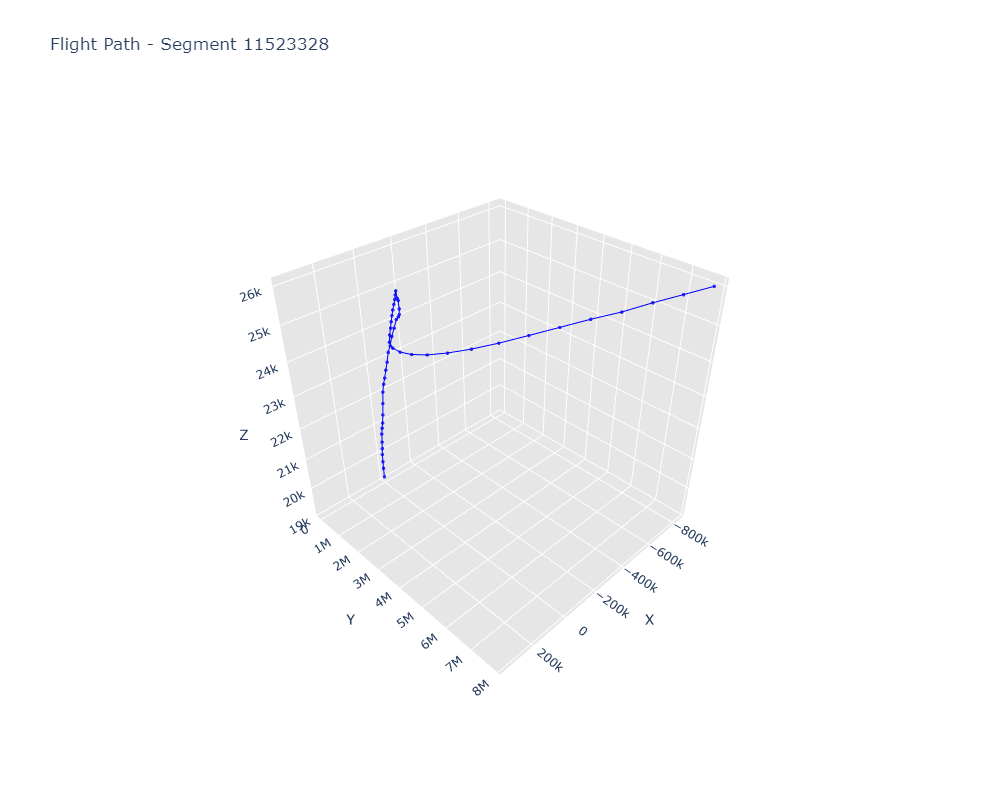

In [6]:
Image("flight_path.png")

In [7]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import random
import plotly.express as px  # for the color sequence

# Filter for cluster 1
cluster_data = trajectories[trajectories['cluster'] == 1]

# Convert decimal columns to float if needed
numeric_columns = ['x', 'y', 'z']
for col in numeric_columns:
    if cluster_data[col].dtype == 'object':
        cluster_data[col] = cluster_data[col].astype(float)

# Get unique segment IDs for cluster 1
unique_segments = cluster_data['segment_id'].unique()

# Get random sample of up to 50 segment IDs
n_segments = min(50, len(unique_segments))
selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)

# Calculate overall ranges for consistent scaling
x_min, x_max = cluster_data['x'].min(), cluster_data['x'].max()
y_min, y_max = cluster_data['y'].min(), cluster_data['y'].max()
z_min, z_max = cluster_data['z'].min(), cluster_data['z'].max()
max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)

# Create a color sequence
colors = px.colors.qualitative.Set3  # Using Set3 palette which has good visibility for multiple traces
# If we need more colors than available in the palette, we'll cycle through them
colors = colors * (n_segments // len(colors) + 1)

# Create the 3D scatter plot
fig = go.Figure()

# Add each trajectory as a separate trace
for idx, segment_id in enumerate(selected_segments):
    segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
    
    fig.add_trace(go.Scatter3d(
        x=segment_data['x'],
        y=segment_data['y'],
        z=segment_data['z'],
        mode='lines',
        line=dict(
            width=2,
            color=colors[idx]
        ),
        opacity=0.8,  # Increased opacity a bit since we have different colors
        name=f'Segment {segment_id}'
    ))

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Paths - Cluster 1 (Random {n_segments} Segments)',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube',
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(z_min - max_range*0.1), float(z_max + max_range*0.1)]
        )
    ),
    width=1000,
    height=800,
    showlegend=True
)

# Display interactive plot
fig.show()

# Save static version
pio.write_image(fig, "cluster1_paths_colored.png")

print(f"Total number of segments in cluster 1: {len(unique_segments)}")
print(f"Number of segments plotted: {n_segments}")

Total number of segments in cluster 1: 135
Number of segments plotted: 50


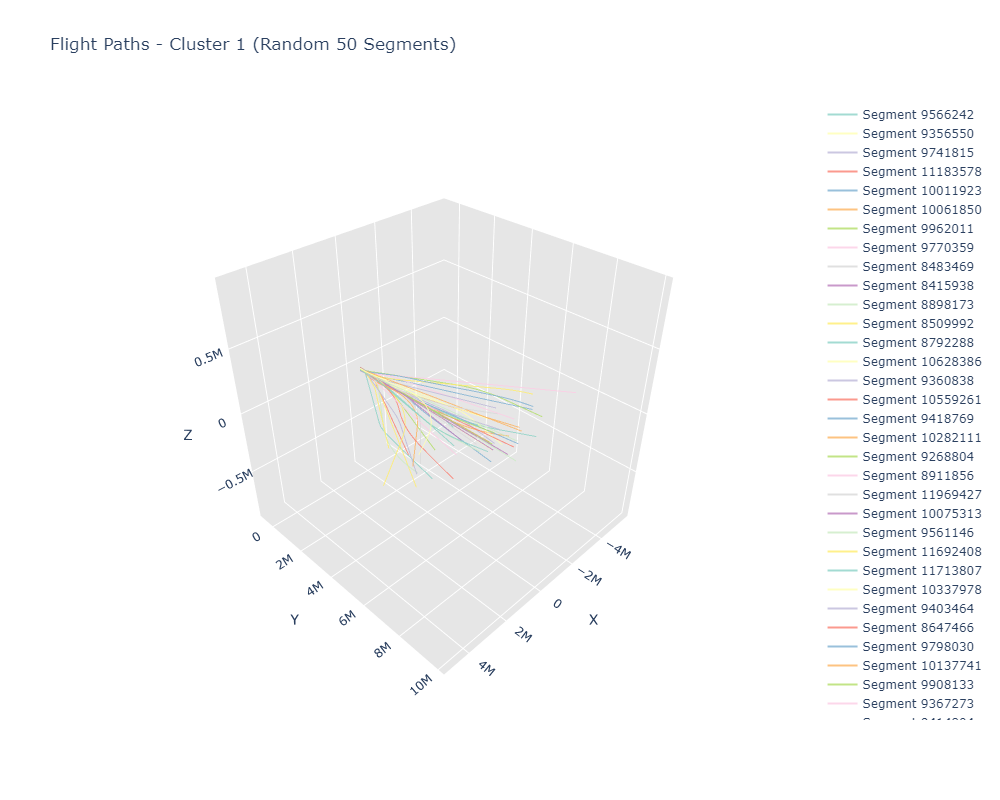

In [8]:
Image("cluster1_paths_colored.png")